## Imports and Setup

Necessary Input: Cell Line ID ie ACH-000019

In [9]:
import os

BILLING_PROJECT_ID = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE = os.environ['WORKSPACE_NAME']
bucket = os.environ['WORKSPACE_BUCKET']

In [2]:
!gcloud storage cp $bucket/* .

Copying gs://fc-6432ab48-f392-48b4-bfc0-43d3f3ad482e/CRISPR_DepMap_Chronos.tsv to file://./CRISPR_DepMap_Chronos.tsv
Copying gs://fc-6432ab48-f392-48b4-bfc0-43d3f3ad482e/CRISPR_DepMap_Chronos_MCF7.tsv to file://./CRISPR_DepMap_Chronos_MCF7.tsv
Copying gs://fc-6432ab48-f392-48b4-bfc0-43d3f3ad482e/CRISPR_DepMap_DEMETER.tsv to file://./CRISPR_DepMap_DEMETER.tsv
Copying gs://fc-6432ab48-f392-48b4-bfc0-43d3f3ad482e/EFO_0000305_associations_export.tsv to file://./EFO_0000305_associations_export.tsv
Copying gs://fc-6432ab48-f392-48b4-bfc0-43d3f3ad482e/OmicsSomaticMutations.csv to file://./OmicsSomaticMutations.csv
Copying gs://fc-6432ab48-f392-48b4-bfc0-43d3f3ad482e/domains.bedpe to file://./domains.bedpe
Copying gs://fc-6432ab48-f392-48b4-bfc0-43d3f3ad482e/loops.bedpe to file://./loops.bedpe
  Completed files 7/7 | 872.4MiB/872.4MiB | 120.7MiB/s                         

Average throughput: 112.5MiB/s


In [10]:
from pathlib import Path
import pandas as pd
from scipy.stats import zscore
import requests


## Load CRISPR Whole Dataset

In [11]:
cell_id = 'ACH-000019'

In [12]:
depmap_CRISPR_filepath = Path('CRISPR_DepMap_Chronos.tsv')
df_crispr = pd.read_csv(depmap_CRISPR_filepath, delimiter='\t')
df_crispr.set_index('entity:sample_id', inplace=True)
# apply z score across genes
df_crispr_z = df_crispr.apply(zscore)
# take out subset
df_crispr_z_subset_sorted = pd.DataFrame(df_crispr_z, index=[cell_id]) # # MCF7 id is ACH-000019
df_crispr_z_subset_sorted = df_crispr_z_subset_sorted.sort_values(by = cell_id, axis=1)
df_crispr_z_subset_sorted

,ESR1,BCAS1,BMP7,FOXA1,GATA3,GABARAPL2,TBX2,TFAP2C,NTNG1,TCHHL1,...,ZNF85,ZNF888,ZNF98,ZNG1A,ZNG1B,ZSCAN12,ZSCAN26,ZSCAN5B,ZSCAN5C,ZSWIM9
ACH-000019,-8.555973,-7.984732,-7.785212,-7.399413,-5.849906,-5.608689,-5.557654,-5.476954,-5.289172,-5.260549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Query Ensembl for Coordinates

In [13]:
n=10

In [14]:
top_dependencies = df_crispr_z_subset_sorted.columns.tolist()[:n]

# https://rest.ensembl.org/documentation/info/symbol_lookup
crispr_results = []

for gene in top_dependencies: 
    base = "https://rest.ensembl.org"
    url = f"/lookup/symbol/homo_sapiens/{gene}?expand=1;content-type=application/json"
    response = requests.get(base+url)
    if response.status_code == 200:
        resp = response.json()
        chr_num = resp['seq_region_name']
        st = resp['start']
        end = resp['end']
        print(f'{gene}  chr{chr_num}:{st}-{end}')
        crispr_results.append([gene, chr_num, st, end])
    else:
        print ('Boo!')

ESR1  chr6:151656691-152129619
BCAS1  chr20:53936777-54070594
BMP7  chr20:57168753-57266641
FOXA1  chr14:37589552-37596059
GATA3  chr10:8045378-8075198
GABARAPL2  chr16:75566375-75577881
TBX2  chr17:61399843-61409466
TFAP2C  chr20:56629306-56639283
NTNG1  chr1:107140007-107484923
TCHHL1  chr1:152084141-152089064


In [15]:
del df_crispr
del df_crispr_z

## Load RNAi Dataset and Run Same Analysis

In [16]:
depmap_RNAi_filepath = Path('CRISPR_DepMap_DEMETER.tsv')
df_rnai = pd.read_csv(depmap_RNAi_filepath, delimiter='\t')
df_rnai.set_index('Unnamed: 0', inplace=True)
# apply z score across genes
df_rnai_z = df_rnai.apply(zscore)
# take out subset
df_rnai_z_subset_sorted = pd.DataFrame(df_rnai_z, index=[cell_id]) # # MCF7 id is ACH-000019
df_rnai_z_subset_sorted = df_rnai_z_subset_sorted.sort_values(by = cell_id, axis=1)
df_rnai_z_subset_sorted

,MDM4,ESR1,KDM1A,SAFB,MDM2,CCND1,CDK4,STK24,CYP2A6,RPS16,...,RCE1,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,KCNE2,DGCR2,CASP8AP2,SCO2
ACH-000019,-3.736568,-3.133295,-2.906473,-2.488206,-2.211532,-2.051915,-1.979815,-1.882925,-1.880691,-1.772032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
top_dependencies_rnai = df_rnai_z_subset_sorted.columns.tolist()[:n]

# https://rest.ensembl.org/documentation/info/symbol_lookup
rnai_results = []

for gene in top_dependencies_rnai: 
    base = "https://rest.ensembl.org"
    url = f"/lookup/symbol/homo_sapiens/{gene}?expand=1;content-type=application/json"
    response = requests.get(base+url)
    if response.status_code == 200:
        resp = response.json()
        chr_num = resp['seq_region_name']
        st = resp['start']
        end = resp['end']
        print(f'{gene}  chr{chr_num}:{st}-{end}')
        rnai_results.append([gene, chr_num, st, end])
    else:
        print ('Boo!')

MDM4  chr1:204516379-204558120
ESR1  chr6:151656691-152129619
KDM1A  chr1:23019443-23083689
SAFB  chr19:5623035-5668478
MDM2  chr12:68808177-68845544
CCND1  chr11:69641156-69654474
CDK4  chr12:57747727-57756013
STK24  chr13:98445185-98577940
CYP2A6  chr19:40843541-40850447
RPS16  chr19:39433137-39435949


In [18]:
del df_rnai
del df_rnai_z

In [19]:
crispr_results

[['ESR1', '6', 151656691, 152129619],
 ['BCAS1', '20', 53936777, 54070594],
 ['BMP7', '20', 57168753, 57266641],
 ['FOXA1', '14', 37589552, 37596059],
 ['GATA3', '10', 8045378, 8075198],
 ['GABARAPL2', '16', 75566375, 75577881],
 ['TBX2', '17', 61399843, 61409466],
 ['TFAP2C', '20', 56629306, 56639283],
 ['NTNG1', '1', 107140007, 107484923],
 ['TCHHL1', '1', 152084141, 152089064]]

In [20]:
rnai_results

[['MDM4', '1', 204516379, 204558120],
 ['ESR1', '6', 151656691, 152129619],
 ['KDM1A', '1', 23019443, 23083689],
 ['SAFB', '19', 5623035, 5668478],
 ['MDM2', '12', 68808177, 68845544],
 ['CCND1', '11', 69641156, 69654474],
 ['CDK4', '12', 57747727, 57756013],
 ['STK24', '13', 98445185, 98577940],
 ['CYP2A6', '19', 40843541, 40850447],
 ['RPS16', '19', 39433137, 39435949]]

## HiC Load

In [18]:
!pip install hic-straw
!pip install juicebox-notebook

  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.13.1-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
  Created wheel for hic-straw: filename=hic_straw-1.3.1-cp310-cp310-linux_x86_64.whl size=141696 sha256=b69dfee6169c518f25b56c1cb580e07c43b18a976cf60ce29b9846166b4da4c4
  Stored in directory: /home/jupyter/.cache/pip/wheels/23/85/e0/14f1be833ddf1da34165e04938653e00b602eb93e834497ae4
Successfully built hic-straw

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 1.8 MB/s eta 0:00:00a 0:00:01m

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [25]:
import numpy as np
import pandas as pd
import hicstraw

mcf7 = "ENCFF420JTA"
hic = hicstraw.HiCFile(f'https://www.encodeproject.org/files/{mcf7}/@@download/{mcf7}.hic')

In [26]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1,1,1),(1,0,0)])
# helper function for plotting
def plot_hic_map(dense_matrix, maxcolor):
    plt.matshow(dense_matrix, cmap=REDMAP, vmin=0, vmax=maxcolor)
    plt.show()

In [27]:
chr_sizes = {
    '1': 248956422,
    '2': 242193529,
    '3': 198295559,
    '4': 190214555,
    '5': 181538259,
    '6': 170805979,
    '7': 159345973,
    '8': 145138636,
    '9': 138394717,
    '10': 133797422,
    '11': 135086622,
    '12': 133275309,
    '13': 114364328,
    '14': 107043718,
    '15': 101991189,
    '16': 90338345,
    '17': 83257441,
    '18': 80373285,
    '19': 58617616,
    '20': 64444167,
    '21': 46709983,
    '22': 50818468,
    'X': 156040895,
    'Y': 57227415,
    'M': 16569,
}

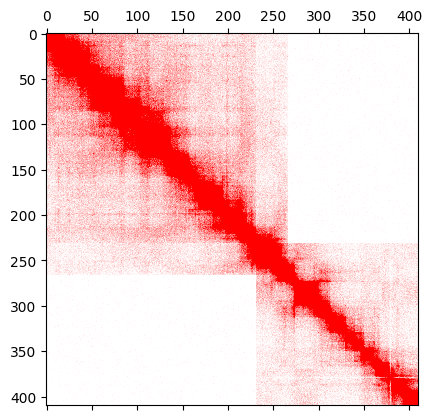

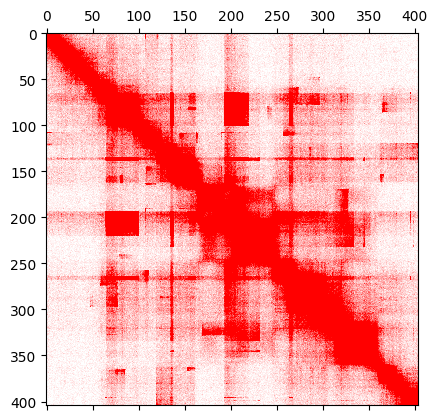

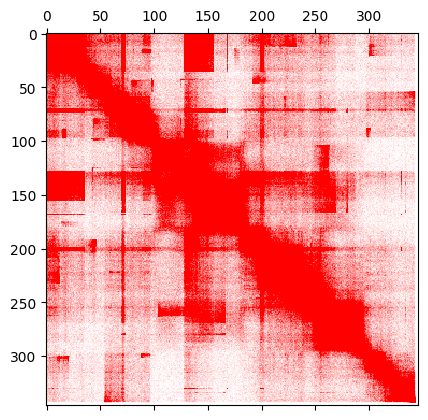

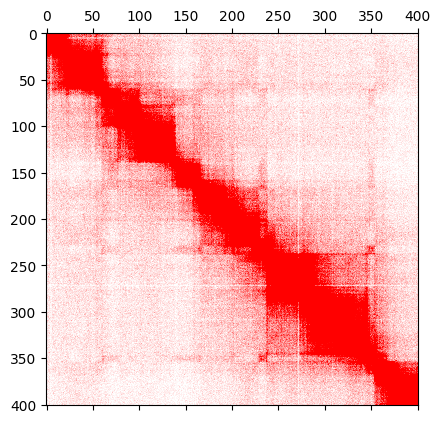

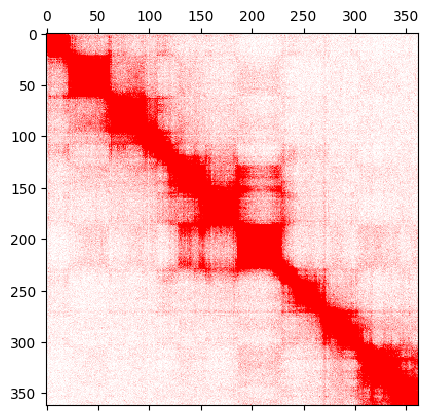

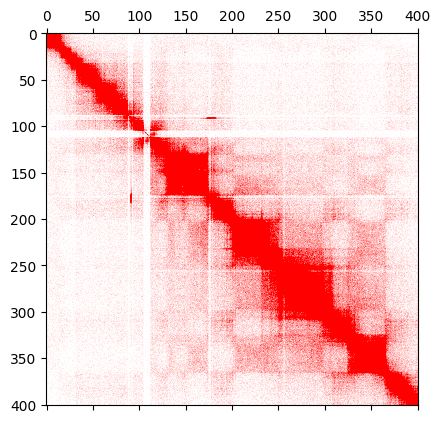

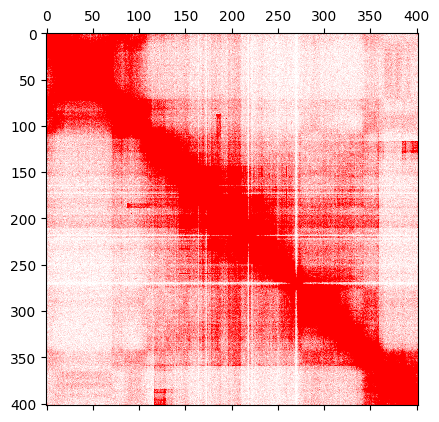

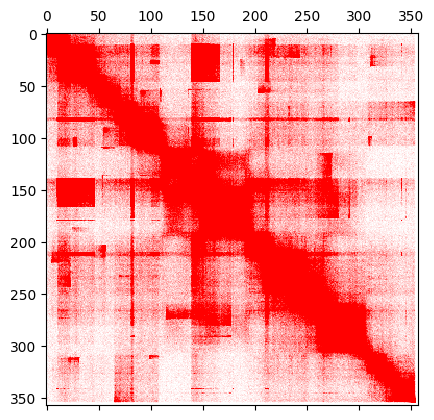

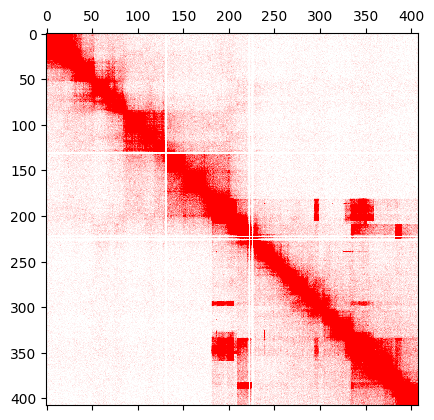

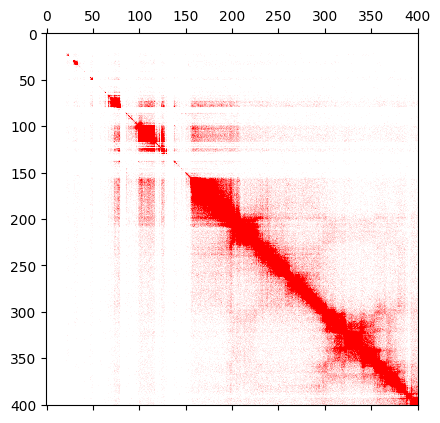

In [28]:
for res in crispr_results: 
    chrom = res[1]
    matrix_object = hic.getMatrixZoomData(f'chr{chrom}', f'chr{chrom}', 'observed', 'NONE', 'BP', 50000)
    start = int(max(0, res[2]-10e6))
    end = int(min(chr_sizes[res[1]], res[3]+10e6))
    numpy_matrix = matrix_object.getRecordsAsMatrix(start, end, start, end) 
    del matrix_object
    plot_hic_map(numpy_matrix, 30)
    del numpy_matrix

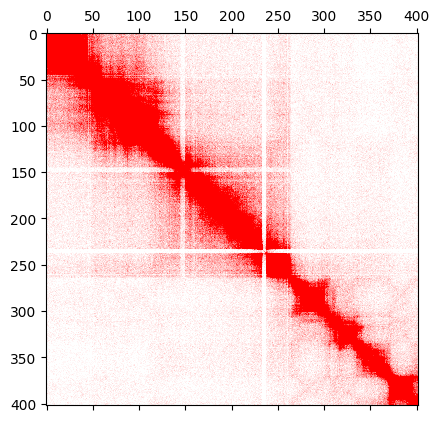

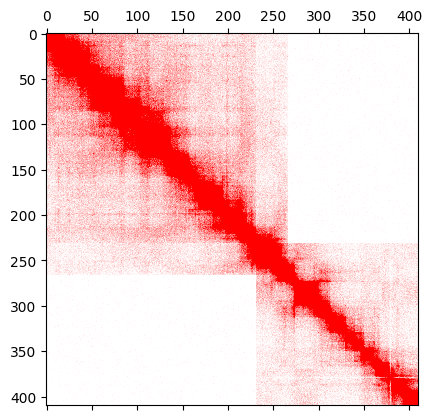

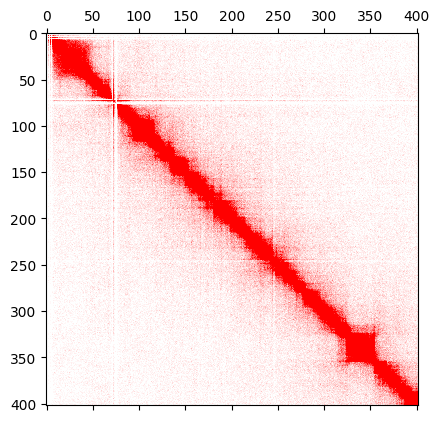

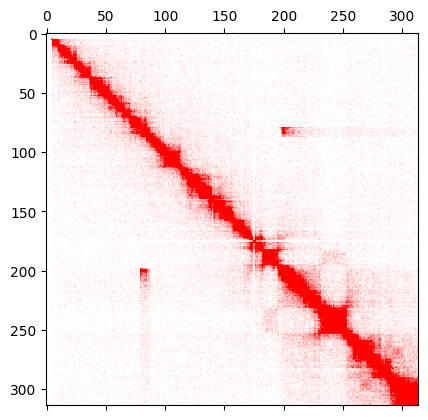

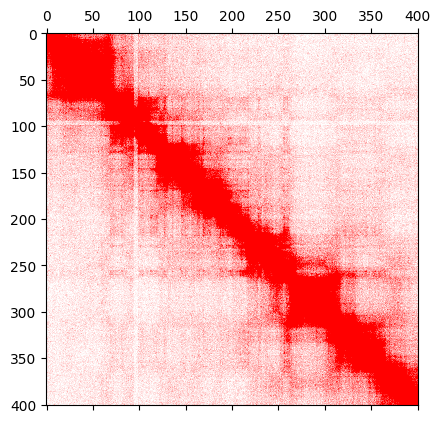

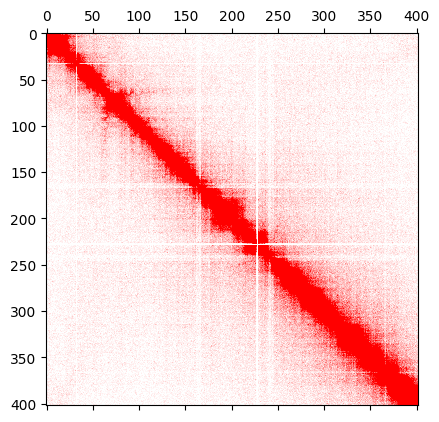

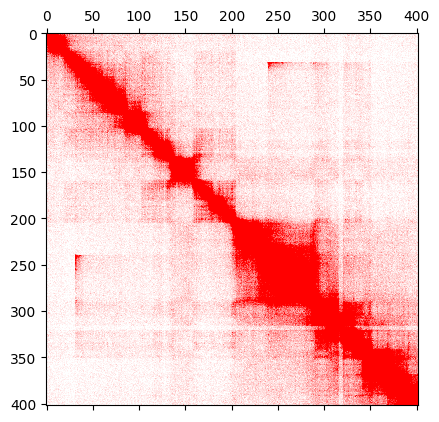

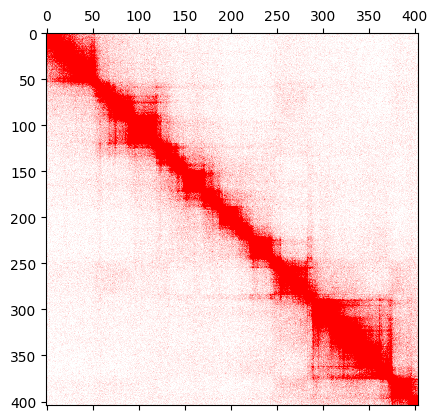

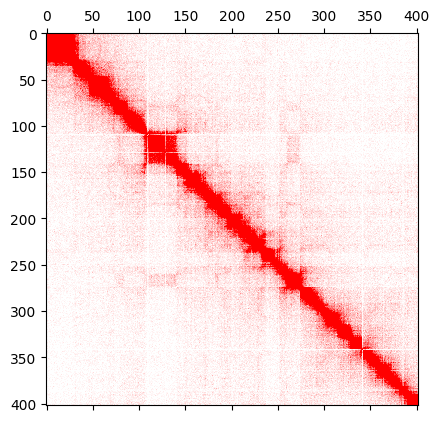

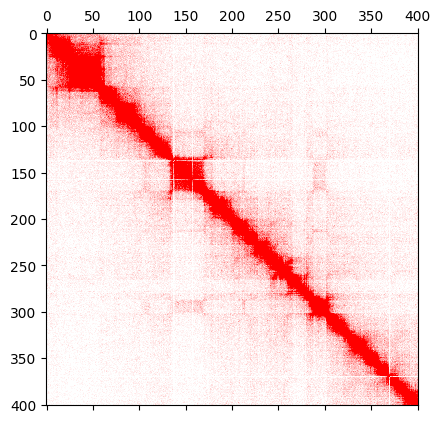

In [29]:
for res in rnai_results: 
    chrom = res[1]
    matrix_object = hic.getMatrixZoomData(f'chr{chrom}', f'chr{chrom}', 'observed', 'NONE', 'BP', 50000)
    start = int(max(0, res[2]-10e6))
    end = int(min(chr_sizes[res[1]], res[3]+10e6))
    numpy_matrix = matrix_object.getRecordsAsMatrix(start, end, start, end) 
    del matrix_object
    plot_hic_map(numpy_matrix, 30)
    del numpy_matrix